<a href="https://colab.research.google.com/github/sfarias03/Education-Inequality/blob/main/SF_Analysis_Education_Inequality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This research project focuses on addressing the issue of educational inequality in American high schools. To gain insights into this issue, data was gathered from EdGap.org and the National Center for Education Statistics. The project specifically looked at the relationship between ACT/SAT exam scores and various socioeconomic factors, such as household income, unemployment rates, and children who benefit from the free/reduced price lunch program. By analyzing this data, the project aimed to gain a deeper understanding of the factors that contribute to unequal educational outcomes in American high schools.

For this purpose of this project SAT scores have been converted to ACT scores.

## Import libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno

from sklearn.linear_model import LinearRegression

from mpl_toolkits.mplot3d import Axes3D

import statsmodels.formula.api as smf
from mpl_toolkits import mplot3d
from matplotlib import cm

from sklearn import linear_model, tree
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

# Model preprocessing
from sklearn.preprocessing import StandardScaler

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.anova import anova_lm

import plotly.offline as pyo
import plotly.graph_objs as go

from itertools import combinations

## Load clean data

In [25]:
df = pd.read_csv('https://raw.githubusercontent.com/sfarias03/Education-Inequality/main/clean_education_inequality-2.csv')

## State your question

The primary objective is to investigate the relationship between socioeconomic factors and the average ACT performance of schools.

One particular question we can explore is: which factors play the most significant role in determining ACT scores? 

A specific question that we investigate later in this notebook is the relationship between ACT/SAT scores and socioeconomic factors in Washington state compared to Illinois state. Since these two states share similarities in terms of politics, median income, and the number of children who benefit from the free/reduced price lunch program, we are interested in exploring whether their test scores would be comparable or not.

In [26]:
all_predictors = ['median_income', 'percent_college', 'percent_lunch', 'percent_married', 'rate_unemployment']

In [27]:
X = df[all_predictors]
y = df['average_act']

In [28]:
def best_subset_selection(X, y):
    variable_names = X.columns.values

    number_variables = len(variable_names)

    # Initialize empty arrays to hold the AIC, BIC, and adjusted r-squared for the best model 
    # at each number of predictors
    best_aic = np.zeros(number_variables)
    best_bic = np.zeros(number_variables)
    best_adjusted_rsquared = np.zeros(number_variables)

    # Initialize empty list to hold the names of the best predictors at each number of predictors
    best_predictors = list()

    # Loop over possible numbers of predictors
    for k in range(number_variables):

        # Get the names of all combinations of k+1 predictors
        subset_names = list(combinations(variable_names, k+1))

        # Loop over all models with k+1 predictors
        for n, predictor_names in enumerate(subset_names):

            # Fit the model
            predictors_subset = X.loc[:, predictor_names]

            model = sm.OLS(y, sm.add_constant(predictors_subset)).fit() 

            # Initialize the best values with the first model
            if n == 0:

                best_rsquared_k = model.rsquared
                best_aic_k = model.aic
                best_bic_k = model.bic
                best_adjusted_rsquared_k = model.rsquared_adj
                best_predictors_k = predictor_names

            # If a model has a better r-squared, update the best values
            elif model.rsquared > best_rsquared_k:

                best_rsquared_k = model.rsquared
                best_aic_k = model.aic
                best_bic_k = model.bic
                best_adjusted_rsquared_k = model.rsquared_adj
                best_predictors_k = predictor_names

        # Record the values for the best model at this number of predictors
        best_bic[k] = best_bic_k
        best_aic[k] = best_aic_k
        best_adjusted_rsquared[k] = best_adjusted_rsquared_k
        best_predictors.append(best_predictors_k)

    return best_aic, best_bic, best_adjusted_rsquared, best_predictors

best_aic, best_bic, best_adjusted_rsquared, best_predictors = best_subset_selection(X, y)
    
print(best_adjusted_rsquared)

[0.6193772  0.6304976  0.63192848 0.63188752 0.63184988]


In [29]:
best_predictors = best_predictors[2]
print(best_predictors)

('percent_college', 'percent_lunch', 'rate_unemployment')


Among the subsets considered, the third subset demonstrates the highest adjusted R-squared value. At this stage, we have successfully identified the key factors that have the most significant influence on ACT scores. Therefore, we will utilize this subset, which consists of three predictors, for further analysis. 

### Model fit with Regression Line - Percent of Students of Assisted Lunch and Average ACT Score

Make a scatter plot with a regression line for `percent_lunch` and `average_act`

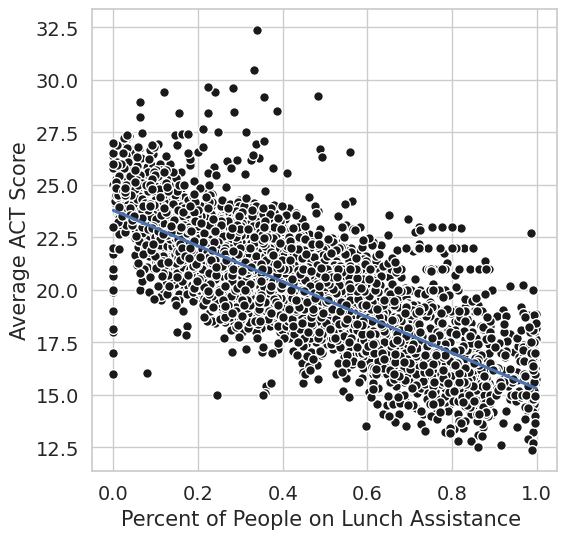

In [30]:
plt.figure(figsize=(6,6))

# Scatter plot 
plt.plot(df['percent_lunch'], df['average_act'], 'ko', mec ='w', ms=7)

# Add the regression line
sns.regplot(data=df, x = 'percent_lunch', y = 'average_act', order=1, scatter=False, ci=None)

# Add axis labels
plt.xlabel('Percent of People on Lunch Assistance ', fontsize=15)
plt.ylabel('Average ACT Score', fontsize=15)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14);

`percent_lunch` model

In [31]:
percent_lunch_model = smf.ols(formula='average_act ~ percent_lunch', data = df).fit()

print(percent_lunch_model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     9407.
Date:                Thu, 11 May 2023   Prob (F-statistic):               0.00
Time:                        00:56:51   Log-Likelihood:                -10753.
No. Observations:                5781   AIC:                         2.151e+04
Df Residuals:                    5779   BIC:                         2.152e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        23.7861      0.041    577.051


Here, we utilized one of the top predictors and generated a scatter plot with a regression line to compare the relationship between percent_lunch and average_act. It is evident that a relationship exists in this case, where a higher percentage of students benefiting from lunch assistance corresponds to a lower average ACT score.

## Heat Map Visualizations

Presented below is a visualization indicating the states from which the data is sourced.

In [32]:
layout = dict(geo={'scope': 'usa'})

data = dict(type='choropleth',
            locations=df['state'].unique(),
            locationmode='USA-states',
            z=np.ones(len(df['state'].unique())),
            text=df['state'].unique())

x = go.Figure(data=[data], layout=layout)

pyo.iplot(x)


The visualization showcases the average ACT scores for each state from which the data is sourced. 

In [33]:
layout = dict(
    geo={'scope': 'usa'},
    title='ACT Scores by State'
)

data = dict(
    type='choropleth',
    locations=df['state'],
    locationmode='USA-states',
    z=df['average_act'],
    text=df['state'],
    colorscale='Viridis',
    colorbar={'title': 'Average ACT Scores'}
)

fig = go.Figure(data = [data], layout = layout)

pyo.iplot(fig)

Median Income by State

In [34]:
layout = dict(
    geo={'scope': 'usa'},
    title='Median Income by State'
)

data = dict(
    type='choropleth',
    locations=df['state'],
    locationmode='USA-states',
    z=df['median_income'],
    text=df['state'],
    colorscale='Viridis',
    colorbar={'title': 'Median Income'}
)

fig2 = go.Figure(data = [data], layout = layout)

pyo.iplot(fig2)

Percent of Students on Assisted Lunch by State

In [69]:
layout = dict(
    geo={'scope': 'usa'},
    title='Percent of Students on Assisted Lunch by State'
)

data = dict(
    type='choropleth',
    locations=df['state'],
    locationmode='USA-states',
    z=df['percent_lunch'],
    text=df['state'],
    colorscale='Viridis',
    colorbar={'title': 'Percent of Students on Assisted Lunch'}
)

fig3 = go.Figure(data = [data], layout = layout)

pyo.iplot(fig3)

These map visualizations reveal that Washington state and Illinois share close similarities, which strengthens the rationale for comparing the two states in our research question. This similarity will be further explored and examined in a more concrete manner in subsequent analyses.

## Prediction

 predictive model designed to estimate ACT scores.

In [68]:
model = smf.ols(formula='average_act ~ median_income + rate_unemployment + percent_lunch + percent_married + percent_college', data = df).fit()

In [56]:
y_prediction = model.predict()

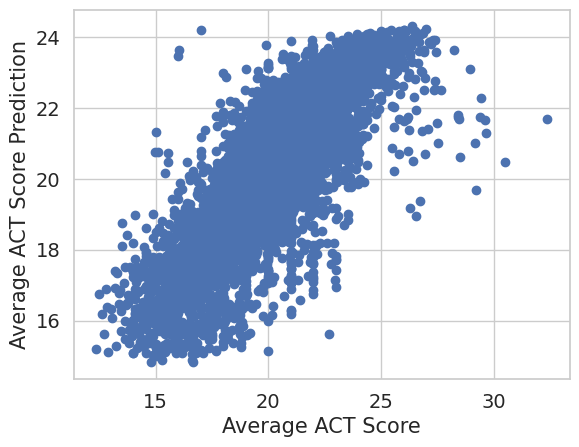

In [57]:
plt.plot(df['average_act'], y_prediction, 'o')

# Add axis labels
plt.xlabel('Average ACT Score', fontsize=15)
plt.ylabel('Average ACT Score Prediction', fontsize=15)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14);

 This plot allows us to visually assess the relationship between the actual and predicted ACT scores. It helps evaluate the performance of the regression model in predicting the average ACT scores and allows us to visually analyze the agreement between the predicted and actual values. In general, the predictions obtained from the model demonstrate a reasonably close approximation to the actual values. 

Next, we will compare the data of Washington and Illinois with the rest of our data frame. To begin with, we need to extract the data of these two states from the rest of the data frame.

In [40]:
def region_from_states(state): 
  if state in ['WA']:
    return 'washington'
  elif state in ['IL']:
    return 'illinois'
  else:
    return 'other'

In [41]:
df['region'] = df['state'].apply(region_from_states)

In [42]:
df[df['region']== 'washington']

,median_income,percent_college,percent_lunch,percent_married,rate_unemployment,school_level,school_type,state,year,zip_code,average_act,region
31,68371.0,0.832136,0.255148,0.525547,0.091684,High,Regular School,WA,2016-2017,98125,23.498168,washington
45,61250.0,0.621197,0.242017,0.661754,0.159808,High,Regular School,WA,2016-2017,98373,21.568987,washington
48,38182.0,0.620830,0.363921,0.615611,0.134357,High,Regular School,WA,2016-2017,98532,22.594628,washington
88,41062.0,0.359717,0.986425,0.731992,0.061127,High,Regular School,WA,2016-2017,98813,18.003663,washington
103,45781.0,0.497257,0.676550,0.560061,0.096353,High,Regular School,WA,2016-2017,98146,18.516484,washington
...,...,...,...,...,...,...,...,...,...,...,...,...
5650,49556.0,0.456219,0.344086,0.640217,0.097105,High,Regular School,WA,2016-2017,98937,19.420024,washington
5683,23438.0,0.627907,0.514218,0.482927,0.110112,High,Regular School,WA,2016-2017,98624,21.739927,washington
5731,37716.0,0.455696,0.372687,0.517602,0.090952,High,Regular School,WA,2016-2017,98233,21.788767,washington
5735,65673.0,0.713380,0.280816,0.659926,0.026611,High,Regular School,WA,2016-2017,98133,22.936508,washington


In [43]:
df[df['region']== 'illinois']

,median_income,percent_college,percent_lunch,percent_married,rate_unemployment,school_level,school_type,state,year,zip_code,average_act,region
9,66492.000000,0.599102,0.230769,0.881449,0.109262,High,Regular School,IL,2016-2017,61024,19.9,illinois
27,76037.000000,0.611076,0.460407,0.768087,0.104948,High,Regular School,IL,2016-2017,60099,18.4,illinois
61,27596.385705,0.418893,0.889632,0.440392,0.152056,High,Regular School,IL,2016-2017,60615,17.7,illinois
76,65398.000000,0.614004,0.228700,0.679654,0.069004,High,Regular School,IL,2016-2017,62670,21.1,illinois
77,50707.000000,0.286855,0.625973,0.529106,0.140100,High,Regular School,IL,2016-2017,60073,18.0,illinois
...,...,...,...,...,...,...,...,...,...,...,...,...
5742,32500.000000,0.549268,0.550775,0.508100,0.166348,High,Regular School,IL,2016-2017,62896,18.6,illinois
5746,78066.000000,0.863728,0.091057,0.903930,0.101664,High,Regular School,IL,2016-2017,61525,24.8,illinois
5749,46893.000000,0.592249,0.198507,0.755285,0.095931,High,Regular School,IL,2016-2017,61523,20.4,illinois
5767,46844.000000,0.640316,0.308140,0.702945,0.042866,High,Regular School,IL,2016-2017,62449,19.3,illinois


In [44]:
df_states_wanted = df[df['region'] != 'other']

Now that we have isolated the data for Washington and Illinois, we can visually compare the two states by plotting their data and analyzing what we see.

<Figure size 600x600 with 0 Axes>

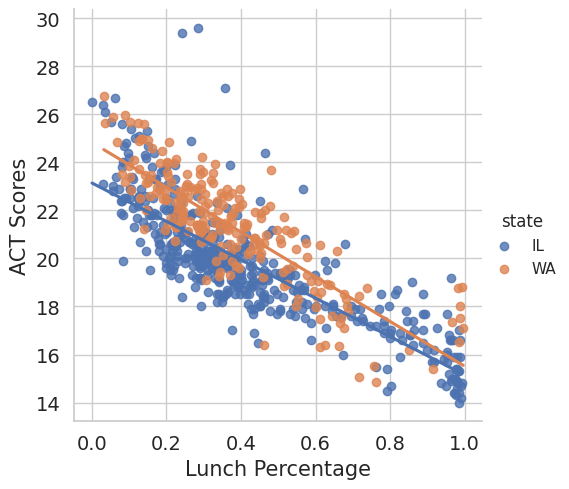

In [45]:
plt.figure(figsize=(6,6))
# Add the regression lines
sns.lmplot(data= df_states_wanted, x = 'percent_lunch', y = 'average_act', hue = 'state', ci=None)

# Add axis labels
plt.xlabel('Lunch Percentage', fontsize=15)
plt.ylabel('ACT Scores', fontsize=15)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14);

Here the comparison between Illinois and Washington reveals a striking similarity in terms of the relationship between the strongest socioeconomic factor, the free/reduced price lunch program, and the average ACT scores.

In [61]:
X = df[list(best_predictors)]

Y = df['average_act']

<Figure size 600x600 with 0 Axes>

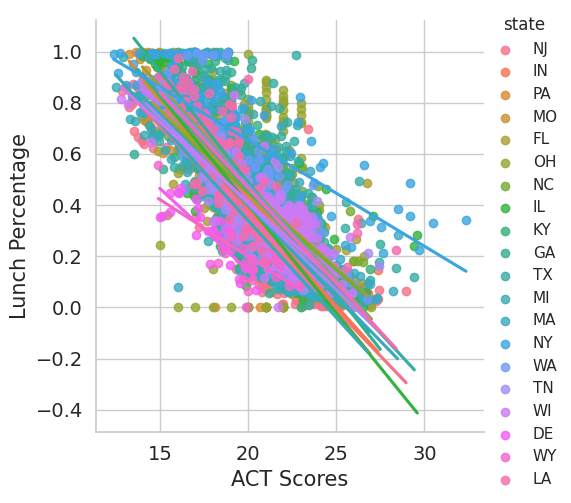

In [37]:
plt.figure(figsize=(6,6))

sns.lmplot(data= df, x = 'average_act', y = 'percent_lunch', hue = 'state', ci=None)

plt.xlabel('ACT Scores', fontsize=15)
plt.ylabel('Lunch Percentage', fontsize=15)

plt.tick_params(labelsize=14);

In a similar vein to our previous analysis, we now examine the data with each state distinctly represented. It becomes evident that regardless of the state, a prevailing trend emerges: students who receive school lunch assistance tend to exhibit lower performance on the ACT/SAT examinations.

# Conclusion


In conclusion, our project provides conclusive evidence of a robust relationship between ACT/SAT scores and socioeconomic factors. This is evident from the high accuracy (R2) of our predictions, the statistically significant coefficients associated with these factors, and the measure of accuracy expressed in ACT units. These findings highlight the crucial role of socioeconomic factors in shaping test scores and emphasize the significance of addressing educational inequality through targeted interventions.

In conducting this research project, it is important to acknowledge certain limitations that may have impacted our findings. Firstly, we must recognize that we may have missed important predictors, such as whether schools require ACT/SAT test-taking or not. Additionally, the availability of data varied across states, with some states having limited or missing overall data. Furthermore, it is worth noting that the SAT underwent changes in 2016, which could have influenced the results. Another limitation is the reliance on indirect measurements of certain conditions for students. Lastly, quality control issues, such as SAT/ACT conversions, may have introduced uncertainties into the analysis. Despite these limitations, our research provides valuable insights into the relationship between ACT/SAT scores and socioeconomic factors. 